In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC
import LogRegAC.crossValdAC as crossValdAC

In [2]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [3]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

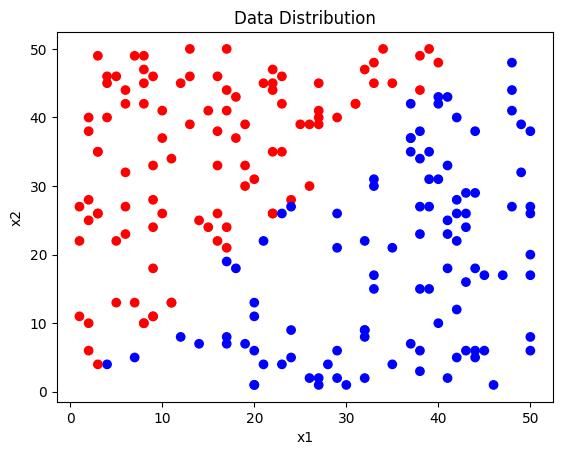

In [4]:
fig = plt.figure()
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Distribution')
plt.show()
fig.savefig('plots/data_dist.png')

In [5]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

thresh = np.arange(0, 1, 0.001)

## Newton's Method

In [6]:
nwt = logRegAC.LogReg(max_iter=100, eps=1e-5, newton=True)
t_beta = nwt.fit(train_x, train_y, iter_step=10, reg_term=1)
nwt_pred = nwt.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, nwt_pred)['f1'])

Implementing Newton's Method.
Iteration     0 | Cost:  187.420
Iteration    10 | Cost:  17.589
Iteration    20 | Cost:  13.509
Iteration    30 | Cost:  11.880
Iteration    40 | Cost:  10.927
Iteration    50 | Cost:  10.276
Iteration    60 | Cost:  9.791
Iteration    70 | Cost:  9.408
Iteration    80 | Cost:  9.095
Iteration    90 | Cost:  8.831
Iteration   100 | Cost:  8.604
F1 Score:  0.975609756097561


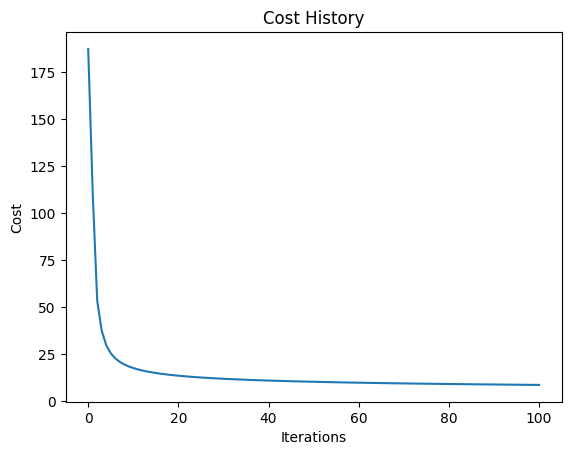

In [7]:
fig = plt.figure()
plt.plot(nwt.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/nwt_cost_hist.png')

In [8]:
nwt_trained_weights = nwt.get_params()
print(f'Trained Weights: {nwt_trained_weights}')
nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
nwt_cf_matrix = [[nwt_cf_info['tn'], nwt_cf_info['fn']], [nwt_cf_info['fp'], nwt_cf_info['tp']]]

Trained Weights: [[  0.99484412]
 [-32.53604289]
 [ 26.61250116]]


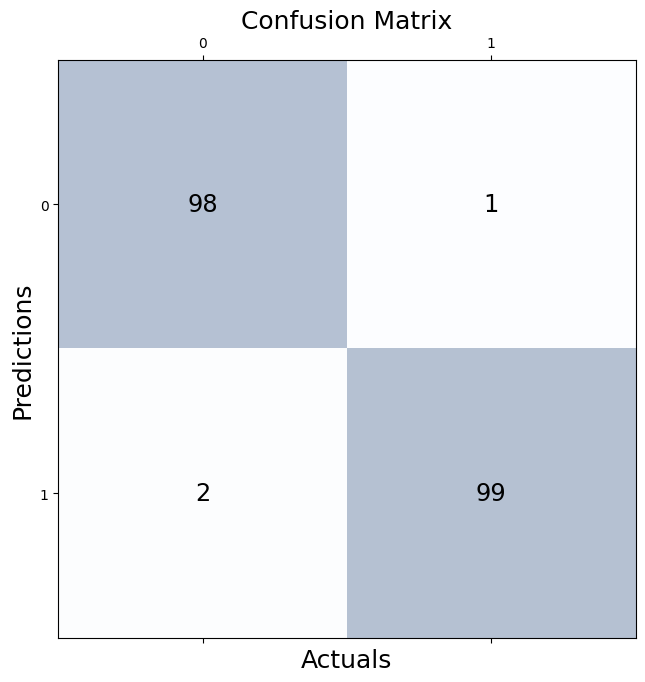

In [9]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(nwt_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(nwt_cf_matrix)):
    for j in range(len(nwt_cf_matrix[i])):
        ax.text(x=j, y=i,s=nwt_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/nwt_confusion_matrix.png')

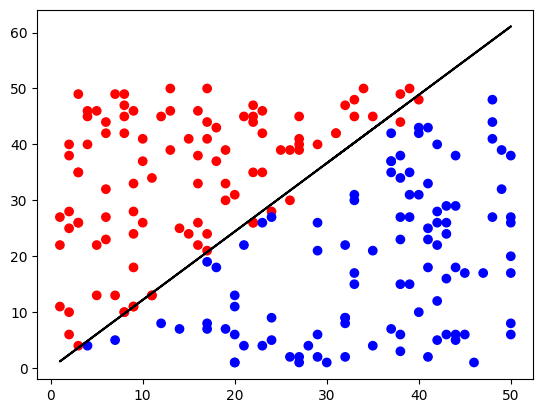

In [10]:
nwt_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], nwt_trained_weights).flatten()
nwt_plot_y = []
for i in range(len(nwt_vals)):
    nwt_plot_y.append(-(nwt_trained_weights[0] + (nwt_trained_weights[1] * data_x.iloc[i, 0])) / nwt_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], nwt_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/nwt_data_dist_db.png')

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:96: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


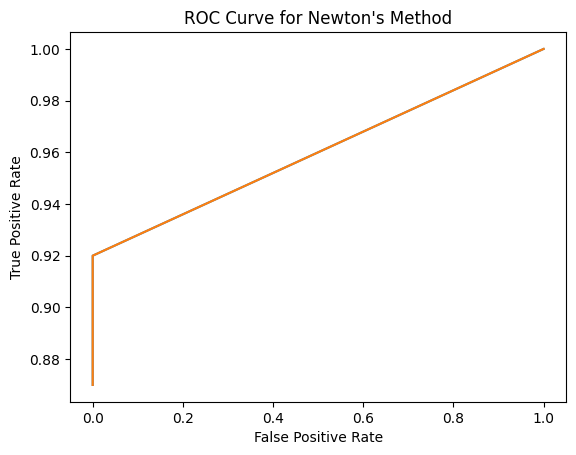

In [11]:
nwt_pred_prob = nwt.predict(data_x, prob=True)
nwt_tpr = []
nwt_fpr = []
for t in thresh:
    nwt_pred = [1 if i >= t else 0 for i in nwt_pred_prob]
    nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt_pred)
    tp = nwt_cf_info['tp']
    fp = nwt_cf_info['fp']
    tn = nwt_cf_info['tn']
    fn = nwt_cf_info['fn']
    nwt_tpr.append(tp/(tp+fn))
    nwt_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(nwt_fpr, nwt_tpr)
plt.plot(nwt_fpr, nwt_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Newton\'s Method')
plt.show()
fig.savefig('plots/nwt_roc.png')

## Using cross-validation Techniques

In [12]:
lrs = [0.01, 0.005, 0.003, 0.001]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'violet', 'purple']

### Holdout Method with Batch Gradient Descent

In [13]:
hld_cv = crossValdAC.CrossVald(option='holdout')
gd_hld_train_costs, gd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  29.945
Iteration   200 | Cost:  22.781
Iteration   300 | Cost:  19.647
Iteration   400 | Cost:  17.787
Iteration   500 | Cost:  16.519
Iteration   600 | Cost:  15.581
Iteration   700 | Cost:  14.849
Iteration   800 | Cost:  14.257
Iteration   900 | Cost:  13.764
Iteration  1000 | Cost:  13.346
F1-score: 0.9538461538461539
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  40.926
Iteration   200 | Cost:  30.787
Iteration   300 | Cost:  26.190
Iteration   400 | Cost:  23.437
Iteration   500 | Cost:  21.554
Iteration   600 | Cost:  20.159
Iteration   700 | Cost:  19.071
Iteration   800 | Cost:  18.192
Iteration   900 | Cost:  17.460
Iteration  1000 | Cost:  16.839
F1-score: 0.9577464788732395
----------------- lr : 0.003 ---

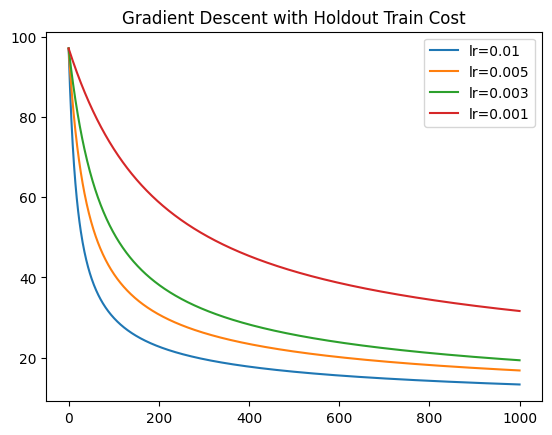

In [14]:
fig = plt.figure()
for i in range(len(gd_hld_train_costs)):
    plt.plot(gd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/gd_hld.png')

In [15]:
print(gd_hld_opt_model)

{'f1': 0.9666666666666666, 'lr': 0.001, 'w': array([[ 0.58440061],
       [-5.68872631],
       [ 4.32810165]])}


In [16]:
best_hld_gd = logRegAC.LogReg()
best_hld_gd.set_params(gd_hld_opt_model['w'])
hld_gd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_gd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_gd_cf_matrix = [[hld_gd_cf_info['tn'], hld_gd_cf_info['fn']], [hld_gd_cf_info['fp'], hld_gd_cf_info['tp']]]

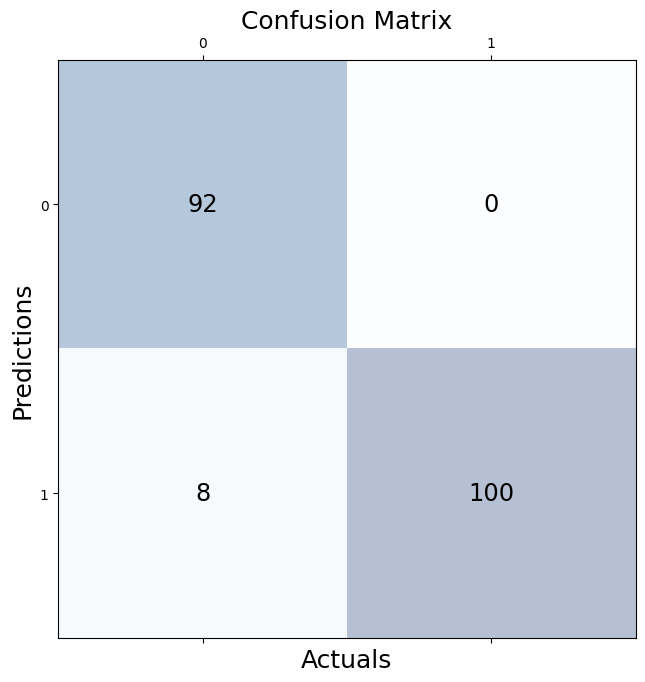

In [17]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_gd_cf_matrix)):
    for j in range(len(hld_gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_gd_confusion_matrix.png')

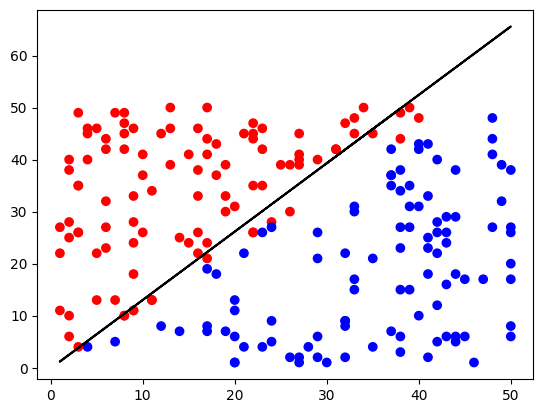

In [18]:
hld_gd_trained_weights = gd_hld_opt_model['w']
hld_gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(hld_gd_vals)):
    gd_plot_y.append(-(hld_gd_trained_weights[0] + (hld_gd_trained_weights[1] * data_x.iloc[i, 0])) / hld_gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_gd_data_dist_db.png')

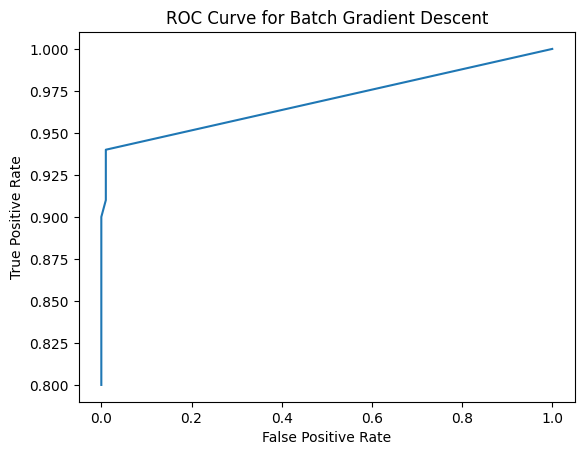

In [19]:
hld_gd_pred_prob = best_hld_gd.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in hld_gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_gd_roc.png')

### Holdout Method with Stochastic Gradient Descent

In [20]:
sgd_hld_train_costs, sgd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.923
Iteration   200 | Cost:  25.516
Iteration   300 | Cost:  22.163
Iteration   400 | Cost:  20.126
Iteration   500 | Cost:  18.711
Iteration   600 | Cost:  17.650
Iteration   700 | Cost:  16.814
Iteration   800 | Cost:  16.132
Iteration   900 | Cost:  15.560
Iteration  1000 | Cost:  15.073
F1-score: 0.9818181818181818
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  42.271
Iteration   200 | Cost:  31.933
Iteration   300 | Cost:  27.233
Iteration   400 | Cost:  24.409
Iteration   500 | Cost:  22.466
Iteration   600 | Cost:  21.018
Iteration   700 | Cost:  19.882
Iteration   800 | Cost:  18.957
Iteration   900 | Cost:  18.184
Iteration  1000 | Cost:  17.523
F1-score: 0.9538461538461539
----------------- lr :

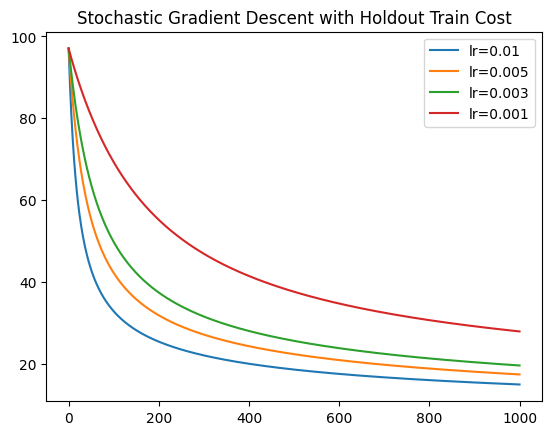

In [21]:
fig = plt.figure()
for i in range(len(sgd_hld_train_costs)):
    plt.plot(sgd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Stochastic Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/sgd_hld.png')

In [22]:
print(sgd_hld_opt_model)

{'f1': 0.9818181818181818, 'lr': 0.01, 'w': array([[  0.48683333],
       [-14.05019877],
       [ 12.01651239]])}


In [23]:
best_hld_sgd = logRegAC.LogReg()
best_hld_sgd.set_params(sgd_hld_opt_model['w'])
hld_sgd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_sgd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_sgd_cf_matrix = [[hld_sgd_cf_info['tn'], hld_sgd_cf_info['fn']], [hld_sgd_cf_info['fp'], hld_sgd_cf_info['tp']]]

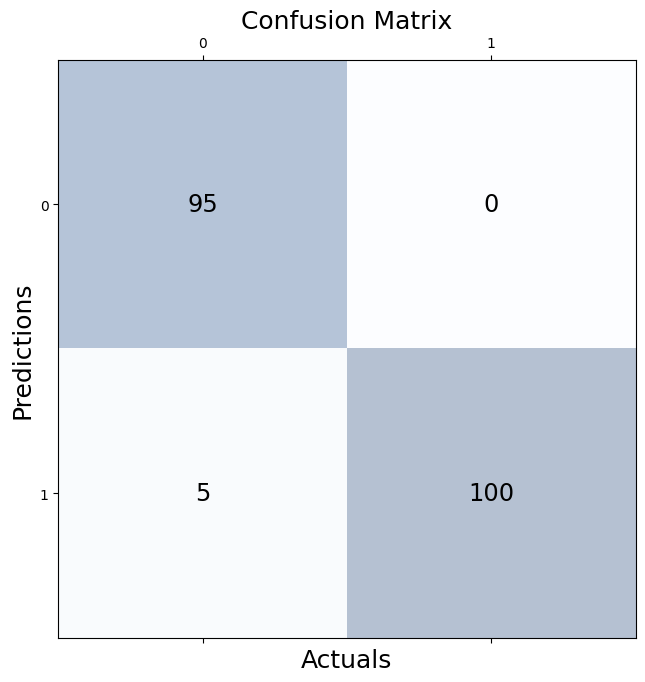

In [24]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_sgd_cf_matrix)):
    for j in range(len(hld_sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_sgd_confusion_matrix.png')

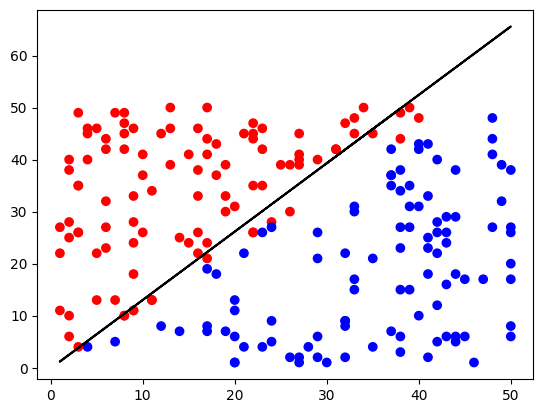

In [25]:
hld_sgd_trained_weights = sgd_hld_opt_model['w']
hld_sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(hld_gd_vals)):
    sgd_plot_y.append(-(hld_sgd_trained_weights[0] + (hld_sgd_trained_weights[1] * data_x.iloc[i, 0])) / hld_sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_sgd_data_dist_db.png')

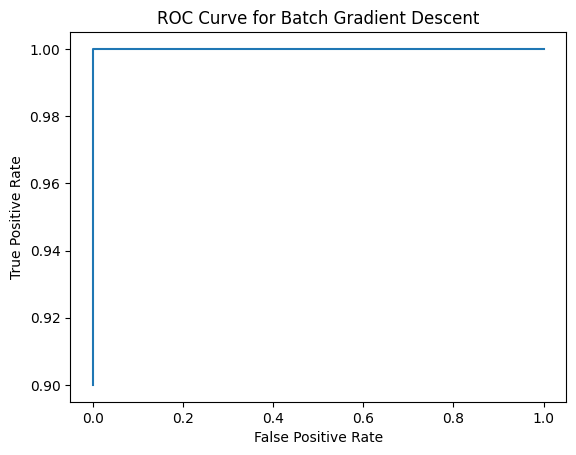

In [26]:
hld_sgd_pred_prob = best_hld_sgd.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in hld_sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_sgd_roc.png')

### Monte Carlo Cross-Validation with Batch Gradient Descent

In [27]:
montc_cv = crossValdAC.CrossVald(option='monte_carlo', monte_carlo=5)
gd_montc_train_costs, gd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.968
Iteration   200 | Cost:  24.648
Iteration   300 | Cost:  21.403
Iteration   400 | Cost:  19.454
Iteration   500 | Cost:  18.112
Iteration   600 | Cost:  17.112
Iteration   700 | Cost:  16.327
Iteration   800 | Cost:  15.690
Iteration   900 | Cost:  15.158
Iteration  1000 | Cost:  14.704
F1-score: 0.96875
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.678
Iteration   200 | Cost:  25.252
Iteration   300 | Cost:  21.904
Iteration   400 | Cost:  19.878
Iteration   500 | Cost:  18.478
Iteration   600 | Cost:  17.431
Iteration   700 | Cost:  16.609
Iteration   800 | Cost:  15.940
Iteration   900 | Cost:  15.381
Iteration  1000 | Cost:  14.905
F1-score: 0.9841269841269841
----------------- lr : 0.01 ------------

In [28]:
print(gd_montc_opt_model)

{'f1': 0.9732607697337847, 'lr': 0.01, 'w': array([[  1.04891165],
       [-14.53223383],
       [ 11.23369763]])}


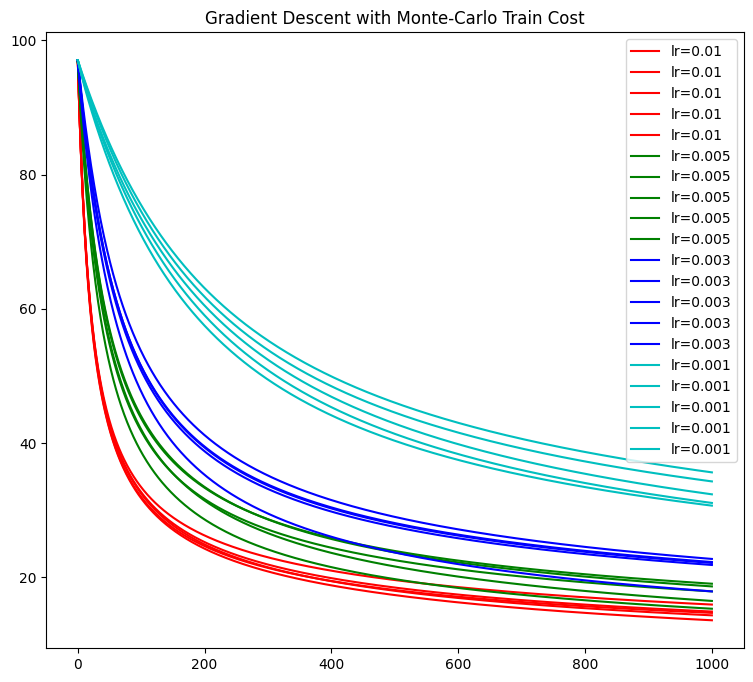

In [29]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_montc_train_costs)):
    for j in range(len(gd_montc_train_costs[i])):
        plt.plot(gd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/gd_montc.png')

### Monte Carlo Cross-Validation with Stochastic Gradient Descent

In [30]:
sgd_montc_train_costs, sgd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.149
Iteration   200 | Cost:  23.908
Iteration   300 | Cost:  20.668
Iteration   400 | Cost:  18.714
Iteration   500 | Cost:  17.364
Iteration   600 | Cost:  16.358
Iteration   700 | Cost:  15.568
Iteration   800 | Cost:  14.926
Iteration   900 | Cost:  14.390
Iteration  1000 | Cost:  13.933
F1-score: 0.9642857142857143
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  30.691
Iteration   200 | Cost:  23.302
Iteration   300 | Cost:  19.989
Iteration   400 | Cost:  17.990
Iteration   500 | Cost:  16.609
Iteration   600 | Cost:  15.578
Iteration   700 | Cost:  14.769
Iteration   800 | Cost:  14.110
Iteration   900 | Cost:  13.560
Iteration  1000 | Cost:  13.092
F1-score: 0.9473684210526316
----------------- l

In [31]:
print(sgd_montc_opt_model)

{'f1': 0.9545796308954204, 'lr': 0.01, 'w': array([[  1.55477545],
       [-15.00629469],
       [ 11.32430017]])}


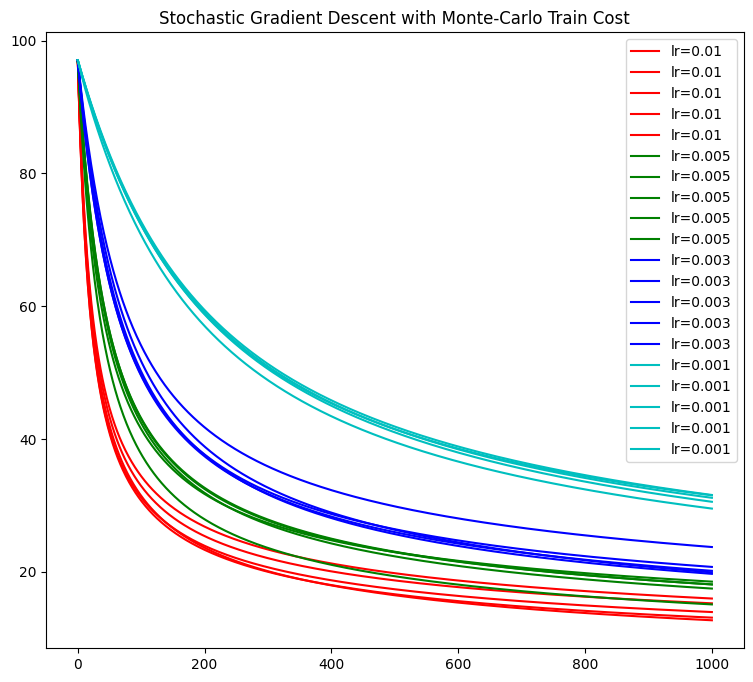

In [32]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_montc_train_costs)):
    for j in range(len(sgd_montc_train_costs[i])):
        plt.plot(sgd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/sgd_montc.png')

In [33]:
kfold_cv = crossValdAC.CrossVald(option='k_fold', k_fold=6)
gd_kfold_train_costs, gd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.297
Iteration   200 | Cost:  28.217
Iteration   300 | Cost:  24.558
Iteration   400 | Cost:  22.332
Iteration   500 | Cost:  20.784
Iteration   600 | Cost:  19.623
Iteration   700 | Cost:  18.707
Iteration   800 | Cost:  17.960
Iteration   900 | Cost:  17.334
Iteration  1000 | Cost:  16.799
F1-score: 0.9743589743589743
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.400
Iteration   200 | Cost:  26.643
Iteration   300 | Cost:  23.194
Iteration   400 | Cost:  21.122
Iteration   500 | Cost:  19.695
Iteration   600 | Cost:  18.632
Iteration   700 | Cost:  17.799
Iteration   800 | Cost:  17.122
Iteration   900 | Cost:  16.557
Iteration  1000 | Cost:  16.076
F1-score: 1.0
----------------- lr : 0.01 -----------------
I

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   800 | Cost:  18.030
Iteration   900 | Cost:  17.423
Iteration  1000 | Cost:  16.904
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.746
Iteration   200 | Cost:  26.766
Iteration   300 | Cost:  23.203
Iteration   400 | Cost:  21.050
Iteration   500 | Cost:  19.557
Iteration   600 | Cost:  18.438
Iteration   700 | Cost:  17.555
Iteration   800 | Cost:  16.833
Iteration   900 | Cost:  16.227
Iteration  1000 | Cost:  15.708
F1-score: 0.9565217391304348
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  34.377
Iteration   200 | Cost:  26.322
Iteration   300 | Cost:  22.735
Iteration   400 | Cost:  20.578
Iteration   500 | Cost:  19.091
Iteration   600 | Cost:  17.983
Iteration   700 | Cost:  17.113
Iteration   800 | Cost:  16.406
Iteration   900 | Cost:  15.815
Iteration  1000 | Cos

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   600 | Cost:  23.441
Iteration   700 | Cost:  22.265
Iteration   800 | Cost:  21.312
Iteration   900 | Cost:  20.519
Iteration  1000 | Cost:  19.844
F1-score: 0.9411764705882353
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.025
Iteration   200 | Cost:  35.468
Iteration   300 | Cost:  30.253
Iteration   400 | Cost:  27.126
Iteration   500 | Cost:  24.980
Iteration   600 | Cost:  23.384
Iteration   700 | Cost:  22.135
Iteration   800 | Cost:  21.122
Iteration   900 | Cost:  20.276
Iteration  1000 | Cost:  19.555
F1-score: 0.9375
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.660
Iteration   200 | Cost:  35.835
Iteration   300 | Cost:  31.011
Iteration   400 | Cost:  28.130
Iteration   500 | Cost:  26.153
Iteration   600 | Cost:  24.682
Iteration   700 | Cost:  23.530
Iteration   800 

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   600 | Cost:  23.771
Iteration   700 | Cost:  22.626
Iteration   800 | Cost:  21.696
Iteration   900 | Cost:  20.920
Iteration  1000 | Cost:  20.258
F1-score: 1.0
Average F1-score for lr=0.005: 0.962538032454361
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  55.267
Iteration   200 | Cost:  41.378
Iteration   300 | Cost:  34.929
Iteration   400 | Cost:  31.048
Iteration   500 | Cost:  28.388
Iteration   600 | Cost:  26.418
Iteration   700 | Cost:  24.881
Iteration   800 | Cost:  23.639
Iteration   900 | Cost:  22.605
Iteration  1000 | Cost:  21.728
F1-score: 0.888888888888889
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.194
Iteration   200 | Cost:  42.586
Iteration   300 | Cost:  36.282
Iteration   400 | Cost:  32.487
Iteration   500 | Cost:  29.883
Iteration   600 | Cost:  27.949
Ite

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   600 | Cost:  28.039
Iteration   700 | Cost:  26.505
Iteration   800 | Cost:  25.267
Iteration   900 | Cost:  24.240
Iteration  1000 | Cost:  23.369
F1-score: 0.9743589743589743
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.739
Iteration   200 | Cost:  45.034
Iteration   300 | Cost:  38.651
Iteration   400 | Cost:  34.819
Iteration   500 | Cost:  32.201
Iteration   600 | Cost:  30.267
Iteration   700 | Cost:  28.760
Iteration   800 | Cost:  27.543
Iteration   900 | Cost:  26.532
Iteration  1000 | Cost:  25.673
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  59.153
Iteration   200 | Cost:  45.666
Iteration   300 | Cost:  39.366
Iteration   400 | Cost:  35.571
Iteration   500 | Cost:  32.967
Iteration   600 | Cost:  31.035
Iteration   700 | Cost:  29.525
Iteration   800 | C

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   600 | Cost:  43.313
Iteration   700 | Cost:  40.684
Iteration   800 | Cost:  38.550
Iteration   900 | Cost:  36.776
Iteration  1000 | Cost:  35.271
F1-score: 0.975609756097561
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  84.529
Iteration   200 | Cost:  68.666
Iteration   300 | Cost:  59.311
Iteration   400 | Cost:  53.130
Iteration   500 | Cost:  48.709
Iteration   600 | Cost:  45.365
Iteration   700 | Cost:  42.729
Iteration   800 | Cost:  40.586
Iteration   900 | Cost:  38.800
Iteration  1000 | Cost:  37.283
F1-score: 0.962962962962963
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  81.335
Iteration   200 | Cost:  64.711
Iteration   300 | Cost:  55.190
Iteration   400 | Cost:  49.003
Iteration   500 | Cost:  44.625
Iteration   600 | Cost:  41.337
Iteration   700 | Cost:  38.759
Iterat

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   600 | Cost:  41.413
Iteration   700 | Cost:  38.902
Iteration   800 | Cost:  36.873
Iteration   900 | Cost:  35.192
Iteration  1000 | Cost:  33.771
F1-score: 0.9473684210526316
Average F1-score for lr=0.001: 0.9610767701054393


In [34]:
print(gd_kfold_opt_model)

{'f1': 0.9734737332188607, 'lr': 0.01, 'w': array([[  1.0801381 ],
       [-15.33758434],
       [ 12.06662259]])}


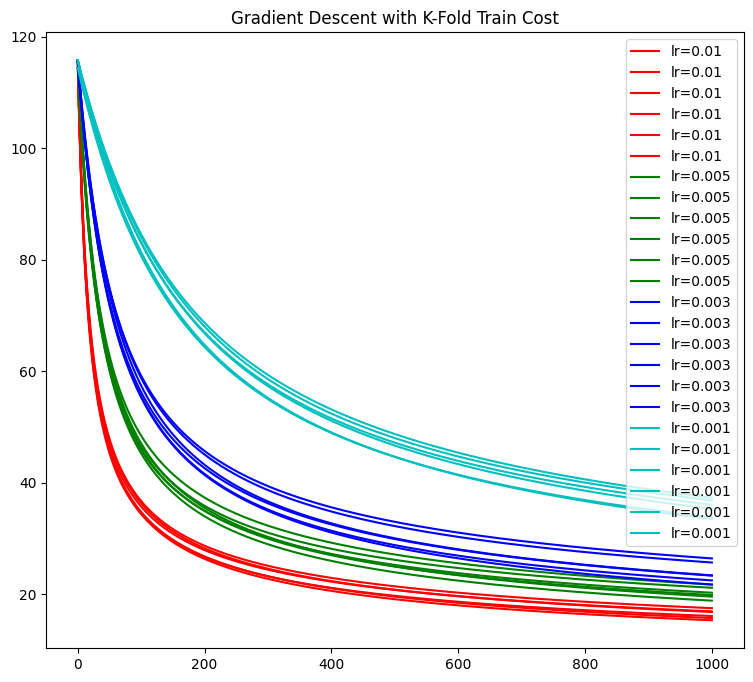

In [35]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_kfold_train_costs)):
    for j in range(len(gd_kfold_train_costs[i])):
        plt.plot(gd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/gd_kfold.png')

In [36]:
sgd_kfold_train_costs, sgd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.019
Iteration   200 | Cost:  26.938


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  23.301
Iteration   400 | Cost:  21.103
Iteration   500 | Cost:  19.585
Iteration   600 | Cost:  18.454
Iteration   700 | Cost:  17.568
Iteration   800 | Cost:  16.848
Iteration   900 | Cost:  16.249
Iteration  1000 | Cost:  15.739
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.962


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  27.893
Iteration   300 | Cost:  24.285
Iteration   400 | Cost:  22.100
Iteration   500 | Cost:  20.582
Iteration   600 | Cost:  19.442
Iteration   700 | Cost:  18.541
Iteration   800 | Cost:  17.805
Iteration   900 | Cost:  17.186
Iteration  1000 | Cost:  16.656
F1-score: 0.9777777777777777
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  34.480
Iteration   200 | Cost:  26.634
Iteration   300 | Cost:  23.155
Iteration   400 | Cost:  21.061
Iteration   500 | Cost:  19.614
Iteration   600 | Cost:  18.533
Iteration   700 | Cost:  17.684
Iteration   800 | Cost:  16.991
Iteration   900 | Cost:  16.412
Iteration  1000 | Cost:  15.917
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.060
Iteration   200 | Cost:  28.137


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  24.585
Iteration   400 | Cost:  22.430
Iteration   500 | Cost:  20.931
Iteration   600 | Cost:  19.803
Iteration   700 | Cost:  18.911
Iteration   800 | Cost:  18.180
Iteration   900 | Cost:  17.565
Iteration  1000 | Cost:  17.038
F1-score: 0.9714285714285714
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.236


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  26.339
Iteration   300 | Cost:  22.819
Iteration   400 | Cost:  20.693
Iteration   500 | Cost:  19.223
Iteration   600 | Cost:  18.123
Iteration   700 | Cost:  17.257
Iteration   800 | Cost:  16.551
Iteration   900 | Cost:  15.960
Iteration  1000 | Cost:  15.455
F1-score: 0.896551724137931
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  36.992
Iteration   200 | Cost:  28.796
Iteration   300 | Cost:  25.132
Iteration   400 | Cost:  22.920
Iteration   500 | Cost:  21.390
Iteration   600 | Cost:  20.244
Iteration   700 | Cost:  19.342
Iteration   800 | Cost:  18.605
Iteration   900 | Cost:  17.987
Iteration  1000 | Cost:  17.459
F1-score: 1.0
Average F1-score for lr=0.01: 0.9742930122240466
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  45.863
Iteration   200 | Cost:  34.717


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  29.747
Iteration   400 | Cost:  26.782
Iteration   500 | Cost:  24.753
Iteration   600 | Cost:  23.248
Iteration   700 | Cost:  22.072
Iteration   800 | Cost:  21.118
Iteration   900 | Cost:  20.324
Iteration  1000 | Cost:  19.648
F1-score: 0.9714285714285714
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.478


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  36.058
Iteration   300 | Cost:  31.009
Iteration   400 | Cost:  28.022
Iteration   500 | Cost:  25.988
Iteration   600 | Cost:  24.484
Iteration   700 | Cost:  23.309
Iteration   800 | Cost:  22.358
Iteration   900 | Cost:  21.564
Iteration  1000 | Cost:  20.888
F1-score: 0.9655172413793104
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  45.817
Iteration   200 | Cost:  34.954
Iteration   300 | Cost:  30.111
Iteration   400 | Cost:  27.216
Iteration   500 | Cost:  25.229
Iteration   600 | Cost:  23.752
Iteration   700 | Cost:  22.593
Iteration   800 | Cost:  21.651
Iteration   900 | Cost:  20.862
Iteration  1000 | Cost:  20.189
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  45.825
Iteration   200 | Cost:  34.990


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  30.133
Iteration   400 | Cost:  27.215
Iteration   500 | Cost:  25.205
Iteration   600 | Cost:  23.705
Iteration   700 | Cost:  22.527
Iteration   800 | Cost:  21.568
Iteration   900 | Cost:  20.765
Iteration  1000 | Cost:  20.080
F1-score: 0.9696969696969697
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.361


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  34.891
Iteration   300 | Cost:  29.739
Iteration   400 | Cost:  26.661
Iteration   500 | Cost:  24.554
Iteration   600 | Cost:  22.991
Iteration   700 | Cost:  21.769
Iteration   800 | Cost:  20.777
Iteration   900 | Cost:  19.951
Iteration  1000 | Cost:  19.247
F1-score: 0.9545454545454545
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  48.566
Iteration   200 | Cost:  37.121
Iteration   300 | Cost:  31.905
Iteration   400 | Cost:  28.763
Iteration   500 | Cost:  26.603
Iteration   600 | Cost:  24.996
Iteration   700 | Cost:  23.738
Iteration   800 | Cost:  22.717
Iteration   900 | Cost:  21.865
Iteration  1000 | Cost:  21.141
F1-score: 0.967741935483871
Average F1-score for lr=0.005: 0.9714883620890294
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  55.838
Iteration   200 | Cost:  42.462


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  36.327
Iteration   400 | Cost:  32.665
Iteration   500 | Cost:  30.169
Iteration   600 | Cost:  28.327
Iteration   700 | Cost:  26.892
Iteration   800 | Cost:  25.733
Iteration   900 | Cost:  24.769
Iteration  1000 | Cost:  23.949
F1-score: 0.9696969696969697
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.824


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  44.682
Iteration   300 | Cost:  38.035
Iteration   400 | Cost:  34.022
Iteration   500 | Cost:  31.269
Iteration   600 | Cost:  29.228
Iteration   700 | Cost:  27.635
Iteration   800 | Cost:  26.344
Iteration   900 | Cost:  25.270
Iteration  1000 | Cost:  24.357
F1-score: 0.972972972972973
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  56.319
Iteration   200 | Cost:  42.195
Iteration   300 | Cost:  35.693
Iteration   400 | Cost:  31.824
Iteration   500 | Cost:  29.198
Iteration   600 | Cost:  27.269
Iteration   700 | Cost:  25.775
Iteration   800 | Cost:  24.572
Iteration   900 | Cost:  23.577
Iteration  1000 | Cost:  22.736
F1-score: 0.9285714285714286
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.701
Iteration   200 | Cost:  42.671


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  36.196
Iteration   400 | Cost:  32.340
Iteration   500 | Cost:  29.724
Iteration   600 | Cost:  27.804
Iteration   700 | Cost:  26.318
Iteration   800 | Cost:  25.123
Iteration   900 | Cost:  24.136
Iteration  1000 | Cost:  23.302
F1-score: 0.9655172413793104
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.798


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  44.873
Iteration   300 | Cost:  38.340
Iteration   400 | Cost:  34.391
Iteration   500 | Cost:  31.677
Iteration   600 | Cost:  29.662
Iteration   700 | Cost:  28.085
Iteration   800 | Cost:  26.807
Iteration   900 | Cost:  25.742
Iteration  1000 | Cost:  24.835
F1-score: 0.975609756097561
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  56.697
Iteration   200 | Cost:  43.373
Iteration   300 | Cost:  37.166
Iteration   400 | Cost:  33.416
Iteration   500 | Cost:  30.834
Iteration   600 | Cost:  28.912
Iteration   700 | Cost:  27.406
Iteration   800 | Cost:  26.181
Iteration   900 | Cost:  25.158
Iteration  1000 | Cost:  24.285
F1-score: 1.0
Average F1-score for lr=0.003: 0.9687280614530405
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.295


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  65.798
Iteration   300 | Cost:  56.257
Iteration   400 | Cost:  50.033
Iteration   500 | Cost:  45.620
Iteration   600 | Cost:  42.305
Iteration   700 | Cost:  39.706
Iteration   800 | Cost:  37.602
Iteration   900 | Cost:  35.856
Iteration  1000 | Cost:  34.378
F1-score: 0.9333333333333333
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  82.825
Iteration   200 | Cost:  66.325
Iteration   300 | Cost:  56.685
Iteration   400 | Cost:  50.357
Iteration   500 | Cost:  45.854
Iteration   600 | Cost:  42.463
Iteration   700 | Cost:  39.802
Iteration   800 | Cost:  37.647
Iteration   900 | Cost:  35.858
Iteration  1000 | Cost:  34.344
F1-score: 0.8387096774193549
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.826
Iteration   200 | Cost:  66.872


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  57.692
Iteration   400 | Cost:  51.704
Iteration   500 | Cost:  47.453
Iteration   600 | Cost:  44.250
Iteration   700 | Cost:  41.732
Iteration   800 | Cost:  39.686
Iteration   900 | Cost:  37.983
Iteration  1000 | Cost:  36.536
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.276


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  66.147
Iteration   300 | Cost:  56.896
Iteration   400 | Cost:  50.876
Iteration   500 | Cost:  46.609
Iteration   600 | Cost:  43.402
Iteration   700 | Cost:  40.884
Iteration   800 | Cost:  38.845
Iteration   900 | Cost:  37.150
Iteration  1000 | Cost:  35.713
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  82.419
Iteration   200 | Cost:  66.034
Iteration   300 | Cost:  56.572
Iteration   400 | Cost:  50.401
Iteration   500 | Cost:  46.026
Iteration   600 | Cost:  42.740
Iteration   700 | Cost:  40.163
Iteration   800 | Cost:  38.077
Iteration   900 | Cost:  36.346
Iteration  1000 | Cost:  34.880
F1-score: 0.9411764705882353
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  84.297


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  68.535
Iteration   300 | Cost:  59.117
Iteration   400 | Cost:  52.867
Iteration   500 | Cost:  48.396
Iteration   600 | Cost:  45.020
Iteration   700 | Cost:  42.366
Iteration   800 | Cost:  40.215
Iteration   900 | Cost:  38.429
Iteration  1000 | Cost:  36.918
F1-score: 0.972972972972973
Average F1-score for lr=0.001: 0.9476987423856493


In [37]:
print(sgd_kfold_opt_model)

{'f1': 0.9742930122240466, 'lr': 0.01, 'w': array([[  0.51655875],
       [-15.0671247 ],
       [ 12.56514771]])}


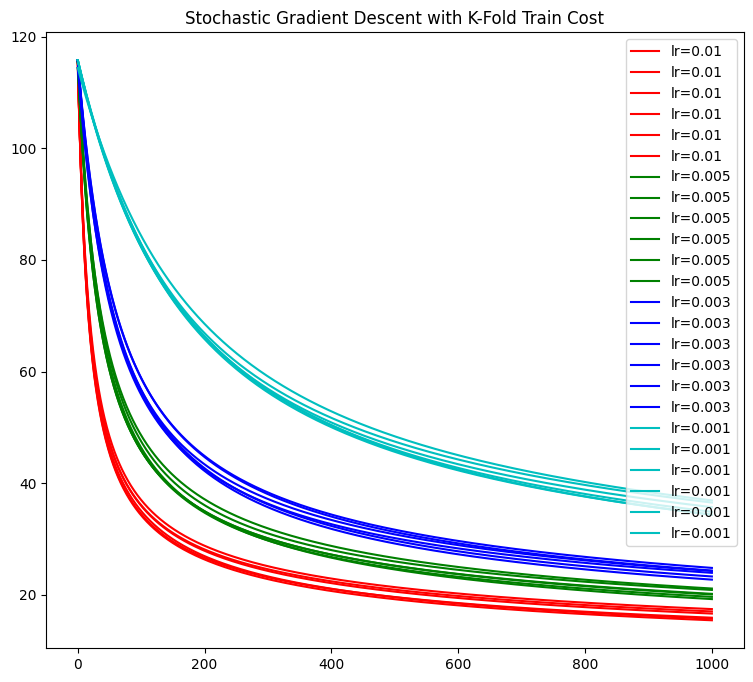

In [38]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_kfold_train_costs)):
    for j in range(len(sgd_kfold_train_costs[i])):
        plt.plot(sgd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/sgd_kfold.png')

## Batch Gradient Descent

In [39]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Implementing Batch Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  34.857
Iteration   200 | Cost:  26.739
Iteration   300 | Cost:  23.115
Iteration   400 | Cost:  20.937
Iteration   500 | Cost:  19.437
Iteration   600 | Cost:  18.319
Iteration   700 | Cost:  17.443
Iteration   800 | Cost:  16.731
Iteration   900 | Cost:  16.136
Iteration  1000 | Cost:  15.629
F1 Score:  0.975609756097561


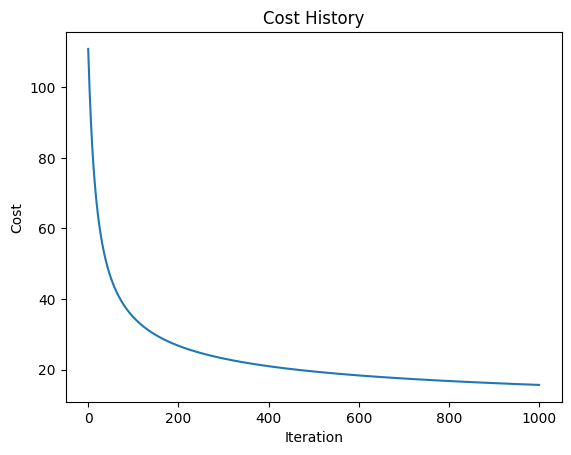

In [40]:
fig = plt.figure()
plt.plot(logReg1.get_cost_hist())
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/gd_cost_hist.png')

In [41]:
gd_trained_weights = logReg1.get_params()
print(f'Trained Weights: {gd_trained_weights}')
gd_cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
gd_cf_matrix = [[gd_cf_info['tn'], gd_cf_info['fn']], [gd_cf_info['fp'], gd_cf_info['tp']]]

Trained Weights: [[  0.83260139]
 [-15.21357532]
 [ 12.1197578 ]]


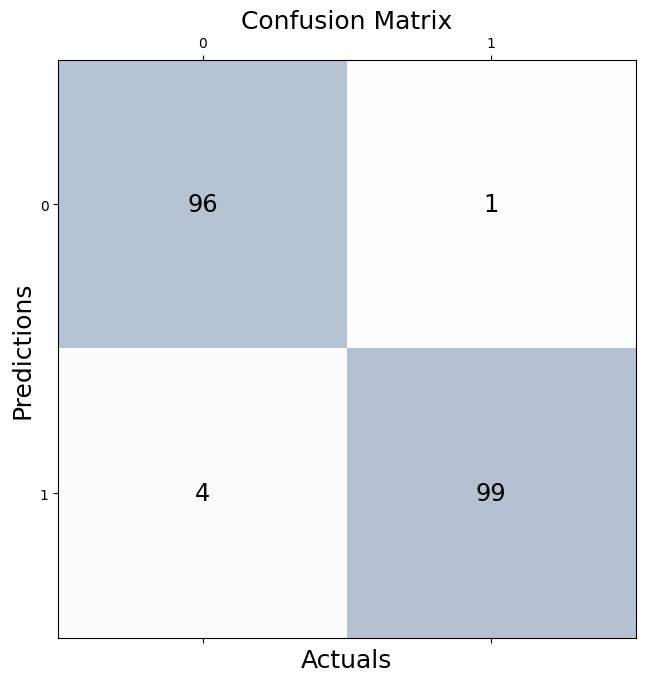

In [42]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(gd_cf_matrix)):
    for j in range(len(gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/gd_confusion_matrix.png')

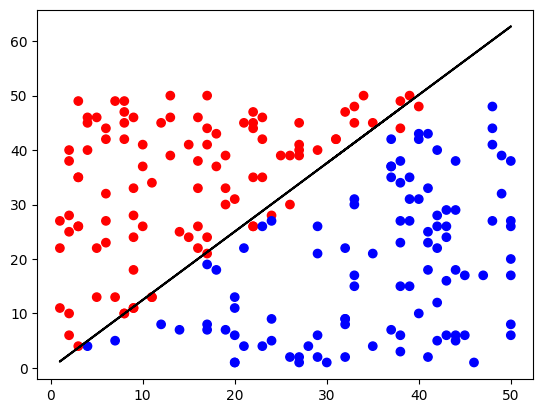

In [43]:
gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(gd_vals)):
    gd_plot_y.append(-(gd_trained_weights[0] + (gd_trained_weights[1] * data_x.iloc[i, 0])) / gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/gd_data_dist_db.png')

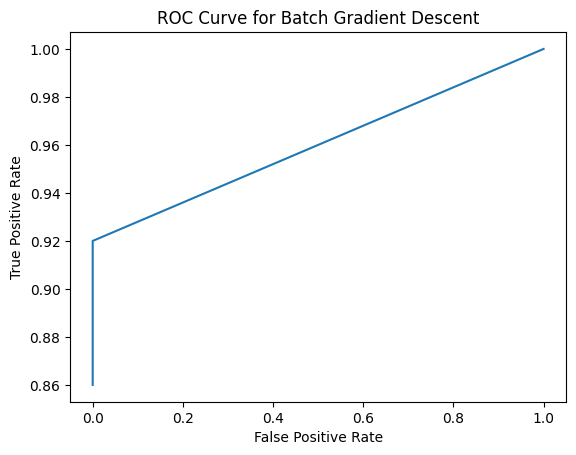

In [44]:
gd_pred_prob = logReg1.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/gd_roc.png')

## Stochastic Gradient Descent

In [45]:
logReg2 = logRegAC.LogReg(lr=0.01, max_iter=1000, stochGD=True)
logReg2.fit(train_x, train_y, iter_step=100)
pred2 = logReg2.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred2)['f1'])

Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  34.966
Iteration   200 | Cost:  26.787
Iteration   300 | Cost:  23.143
Iteration   400 | Cost:  20.955
Iteration   500 | Cost:  19.449
Iteration   600 | Cost:  18.328
Iteration   700 | Cost:  17.450
Iteration   800 | Cost:  16.736
Iteration   900 | Cost:  16.139
Iteration  1000 | Cost:  15.631
F1 Score:  0.975609756097561


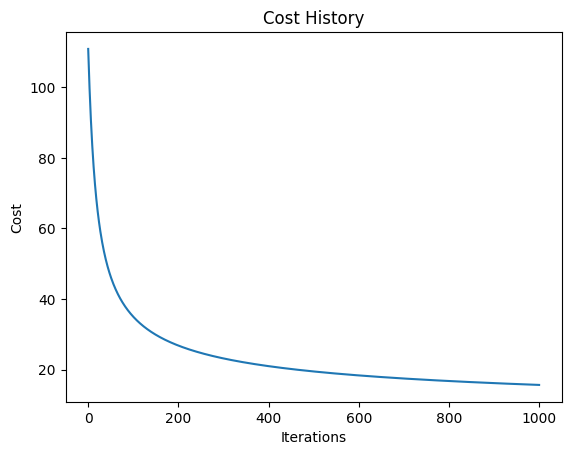

In [46]:
fig = plt.figure()
plt.plot(logReg2.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/sgd_cost_hist.png')

In [47]:
sgd_trained_weights = logReg2.get_params()
print(f'Trained Weights: {sgd_trained_weights}')
sgd_cf_info = utilsAC.get_performance_measure(data_y, logReg2.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
sgd_cf_matrix = [[sgd_cf_info['tn'], sgd_cf_info['fn']], [sgd_cf_info['fp'], sgd_cf_info['tp']]]

Trained Weights: [[  0.83070169]
 [-15.21266727]
 [ 12.11522566]]


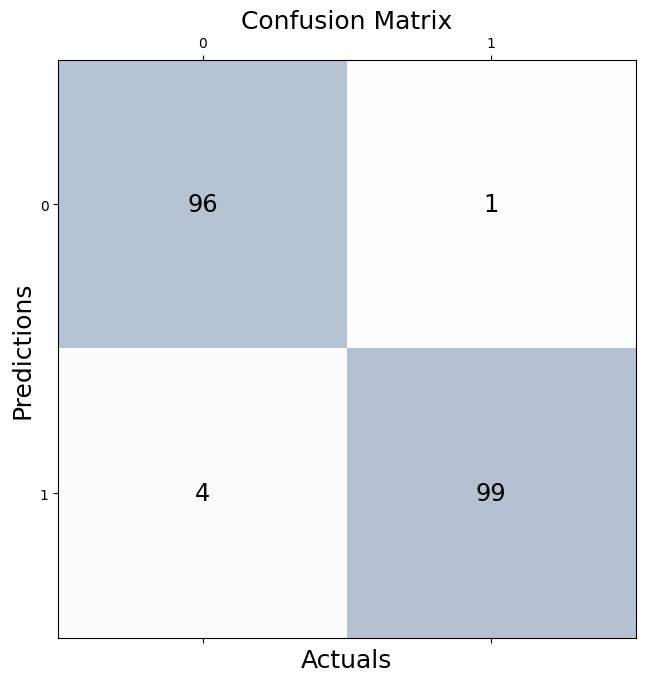

In [48]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(sgd_cf_matrix)):
    for j in range(len(sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/sgd_confusion_matrix.png')

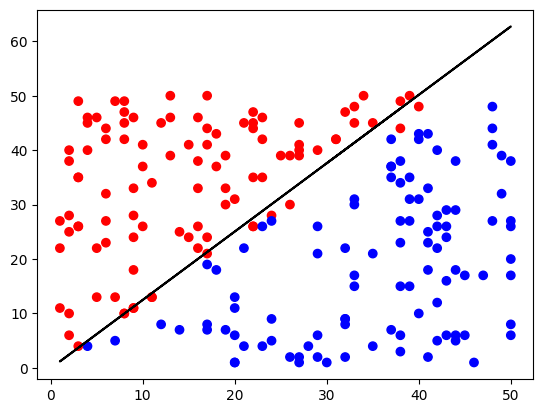

In [49]:
sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(sgd_vals)):
    sgd_plot_y.append(-(sgd_trained_weights[0] + (sgd_trained_weights[1] * data_x.iloc[i, 0])) / sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], sgd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/sgd_data_dist_db.png')

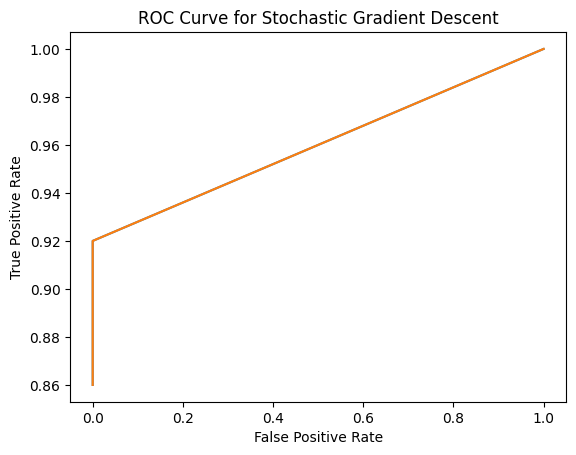

In [50]:
sgd_pred_prob = logReg2.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stochastic Gradient Descent')
plt.show()
fig.savefig('plots/sgd_roc.png')